Following things are used: Comparing classifiers, Best parameter estimation with RandomSearchCV, Imputing NaN values, 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
# Load dataset
dtypes = {'1': 'float64', '2': 'float64', '7': 'float64', '13': 'int64', '14':'float64'}
cc_apps = pd.read_csv("datasets/cc_approvals.data", dtype=dtypes, na_values="?", header=None)

# Inspect data
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


Note: the columns are not explained closer by the source (https://archive.ics.uci.edu/ml/datasets/credit+approval), but according to https://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html they are the following: 
0. Gender (M/F), 1. Age, 2. Debt, 3. Married, 4. BankCustomer, 5. EducationLevel, 6. Ethnicity, 7. YearsEmployed, 8. PriorDefault, 9. Employed, 10. CreditScore, 11. DriversLicense,  12. Citizen, 13. ZipCode, 14. Income, 15. Approved 

# Dataset exploration

In [3]:
# Print summary statistics
cc_apps_description = cc_apps.describe()
print(cc_apps_description)

print('\n')

# Print DataFrame information
cc_apps_info = cc_apps.info()
print(cc_apps_info)

print('\n')

# Inspect missing values in the dataset
print(cc_apps.tail(17))

               1           2           7          10           13  \
count  678.000000  690.000000  690.000000  690.00000   677.000000   
mean    31.568171    4.758725    2.223406    2.40000   184.014771   
std     11.957862    4.978163    3.346513    4.86294   173.806768   
min     13.750000    0.000000    0.000000    0.00000     0.000000   
25%     22.602500    1.000000    0.165000    0.00000    75.000000   
50%     28.460000    2.750000    1.000000    0.00000   160.000000   
75%     38.230000    7.207500    2.625000    3.00000   276.000000   
max     80.250000   28.000000   28.500000   67.00000  2000.000000   

                  14  
count     690.000000  
mean     1017.385507  
std      5210.102598  
min         0.000000  
25%         0.000000  
50%         5.000000  
75%       395.500000  
max    100000.000000  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------

# Feature Engineering

In [4]:
cc_apps["Approved"] = np.where(cc_apps[15]=="+", 1,0)

cc_apps = cc_apps.drop(15, axis=1)
cc_apps

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260.0,0,0
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200.0,394,0
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200.0,1,0
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280.0,750,0


In [5]:
cc_apps.isna().sum(axis=0)

0           12
1           12
2            0
3            6
4            6
5            9
6            9
7            0
8            0
9            0
10           0
11           0
12           0
13          13
14           0
Approved     0
dtype: int64

So features 0 (Gender), 1 (Age), 3 (Married), 4 (BankCustomer), 5 (EducationLevel), 6 (Ethnicity) and 13 (ZipCode) have to be imputed


I decided to add a new feature to indicate how many missing values a row had called "NumNA" and to fill 1 with mean value and 0, 3, 4, 5, 6 and 13 with the most frequent values.

In [6]:
cc_apps["NumNA"] = cc_apps.isnull().sum(axis=1)

In [7]:
def fillna(col):
    if (col.name == 1):
        col.fillna(cc_apps[1].mean(), inplace=True) 
    else:
        col.fillna(col.value_counts().index[0], inplace=True)
    return col

cc_apps=cc_apps.apply(lambda col:fillna(col))

# Count the number of NaNs in the datasets and print the counts to verify
print(cc_apps.isna().sum())

0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
14          0
Approved    0
NumNA       0
dtype: int64


Finally OneHotEncode categorical features

In [8]:
cc_apps = pd.get_dummies(cc_apps, drop_first=True)

In [9]:
cc_apps

,1,2,7,10,13,14,Approved,NumNA,0_b,3_u,...,6_j,6_n,6_o,6_v,6_z,8_t,9_t,11_t,12_p,12_s
0,30.83,0.000,1.25,1,202.0,0,1,0,1,1,...,0,0,0,1,0,1,1,0,0,0
1,58.67,4.460,3.04,6,43.0,560,1,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,24.50,0.500,1.50,0,280.0,824,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,27.83,1.540,3.75,5,100.0,3,1,0,1,1,...,0,0,0,1,0,1,1,1,0,0
4,20.17,5.625,1.71,0,120.0,0,1,0,1,1,...,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,21.08,10.085,1.25,0,260.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
686,22.67,0.750,2.00,2,200.0,394,0,0,0,1,...,0,0,0,1,0,0,1,1,0,0
687,25.25,13.500,2.00,1,200.0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
688,17.92,0.205,0.04,0,280.0,750,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0


Lets create a training and validation split

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(cc_apps.drop(["Approved"], axis=1), cc_apps["Approved"], test_size=0.2, random_state=11)

In [11]:
x_train

,1,2,7,10,13,14,NumNA,0_b,3_u,3_y,...,6_j,6_n,6_o,6_v,6_z,8_t,9_t,11_t,12_p,12_s
4,20.17,5.625,1.710,0,120.0,0,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1
584,28.08,15.000,0.000,0,0.0,13212,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
586,64.08,20.000,17.500,9,0.0,1000,0,1,1,0,...,0,0,0,0,0,1,1,1,0,0
406,40.33,8.125,0.165,2,0.0,18,1,0,0,1,...,0,0,0,1,0,0,1,0,0,0
434,58.58,2.710,2.415,0,320.0,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,34.08,2.500,1.000,0,460.0,16,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
269,18.00,0.165,0.210,0,200.0,40,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0
337,34.83,1.250,0.500,0,160.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
91,31.42,15.500,0.500,0,120.0,0,0,1,1,0,...,0,0,0,1,0,1,0,0,0,0


In [12]:
from sklearn.preprocessing import StandardScaler



# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = StandardScaler()
rescaledX_train = scaler.fit_transform(x_train)
rescaledX_val = scaler.transform(x_val)

Try different models

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score


# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()

rfc = RandomForestClassifier(max_depth=6, n_estimators=300, max_features=5, random_state=0)

svm = LinearSVC()

xgb = xgb.XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.01, random_state=0)

knn = KNeighborsClassifier(n_neighbors=5)

dtc = DecisionTreeClassifier(random_state=0, max_depth=5, max_features=5, min_samples_split=5)

models = [logreg, rfc, xgb, knn, dtc, svm]

In [14]:
ascores = []
for m in models:
    m.fit(rescaledX_train, y_train)
    y_pred = m.predict(rescaledX_val)
    s=accuracy_score(y_val, y_pred)
    ascores.append(s)
    print("------------------------------")
    print("Model: ", m)
    print(s)

------------------------------
Model:  LogisticRegression()
0.8840579710144928
------------------------------
Model:  RandomForestClassifier(max_depth=6, max_features=5, n_estimators=300,
                       random_state=0)
0.8913043478260869
[21:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------------------
Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n

Lets pick XGBClassifier and try to find optimal parameters

In [15]:
import xgboost as xgb
xgb1 = xgb.XGBClassifier()

parameters = {'n_estimators':[300, 650, 1000], 'max_depth':[4, 6, 8], "learning_rate":[0.1, 0.01, 0.001]}

xgb1 = xgb.XGBClassifier()
rscv = RandomizedSearchCV(xgb1, parameters, n_iter=10, cv=2, random_state=0)

In [16]:
rscv.fit(rescaledX_train, y_train)

print(rscv.best_params_)

[21:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [17]:
bm = rscv.best_estimator_
bm.fit(rescaledX_train, y_train)

y_pred = bm.predict(rescaledX_val)

scores = accuracy_score(y_pred, y_val)
scores

[21:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8913043478260869

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        81
           1       0.89      0.84      0.86        57

    accuracy                           0.89       138
   macro avg       0.89      0.88      0.89       138
weighted avg       0.89      0.89      0.89       138



<AxesSubplot:>

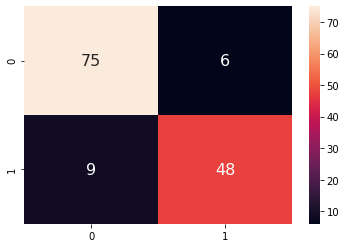

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size

In [20]:
cc_apps

,1,2,7,10,13,14,Approved,NumNA,0_b,3_u,...,6_j,6_n,6_o,6_v,6_z,8_t,9_t,11_t,12_p,12_s
0,30.83,0.000,1.25,1,202.0,0,1,0,1,1,...,0,0,0,1,0,1,1,0,0,0
1,58.67,4.460,3.04,6,43.0,560,1,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,24.50,0.500,1.50,0,280.0,824,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,27.83,1.540,3.75,5,100.0,3,1,0,1,1,...,0,0,0,1,0,1,1,1,0,0
4,20.17,5.625,1.71,0,120.0,0,1,0,1,1,...,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,21.08,10.085,1.25,0,260.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
686,22.67,0.750,2.00,2,200.0,394,0,0,0,1,...,0,0,0,1,0,0,1,1,0,0
687,25.25,13.500,2.00,1,200.0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
688,17.92,0.205,0.04,0,280.0,750,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0


In [21]:
features = cc_apps.drop(["Approved"], axis=1).columns

features

Index([      1,       2,       7,      10,      13,      14, 'NumNA',   '0_b',
         '3_u',   '3_y',  '4_gg',   '4_p',   '5_c',  '5_cc',   '5_d',   '5_e',
        '5_ff',   '5_i',   '5_j',   '5_k',   '5_m',   '5_q',   '5_r',   '5_w',
         '5_x',  '6_dd',  '6_ff',   '6_h',   '6_j',   '6_n',   '6_o',   '6_v',
         '6_z',   '8_t',   '9_t',  '11_t',  '12_p',  '12_s'],
      dtype='object')

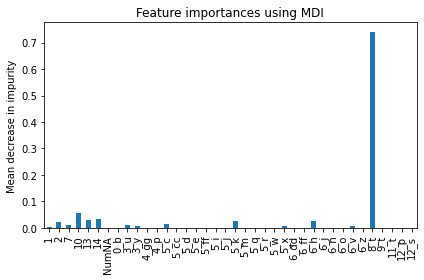

In [22]:
import matplotlib.pyplot as plt


importances = bm.feature_importances_

xgb_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [23]:
xgb_importances.sort_values(ascending=False)

8_t      0.739181
10       0.057542
14       0.035182
13       0.028673
6_h      0.026603
5_k      0.024399
2        0.023617
5_c      0.013531
3_u      0.011756
7        0.010741
5_x      0.008412
3_y      0.007540
6_v      0.006949
1        0.003936
5_i      0.001140
5_cc     0.000660
5_q      0.000139
4_p      0.000000
4_gg     0.000000
5_d      0.000000
NumNA    0.000000
0_b      0.000000
12_s     0.000000
5_e      0.000000
5_ff     0.000000
12_p     0.000000
5_m      0.000000
5_r      0.000000
5_w      0.000000
6_dd     0.000000
6_ff     0.000000
6_j      0.000000
6_n      0.000000
6_o      0.000000
6_z      0.000000
9_t      0.000000
11_t     0.000000
5_j      0.000000
dtype: float32

By far the most important feature is number 8, which is supposed to be PriorDefault and that seems reasonable. Second most important feature is CreditScore, third is Income and fourth interestingly is ZipCode.